## **Airport weekly percentage of weather delays over total delays**

In this notebook we are computing a weekly percentage of the flights that had a delay due to weather. The percentage is computed as the ratio between the number of flights with a weather delay and the total number of flights with a delay.

#### **Initialize PySpark**

In [1]:
# Find Apache Spark on this machine
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

# Dev mode: False when performing real analytics
DEV = False

# Build a Spark SQL Session for DataFrames
master = 'local[2]'
appName = 'Cancelled flights percentages'
spark = SparkSession \
    .builder \
    .appName(appName) \
    .master(master) \
    .getOrCreate()

#### **Load Data**

Try to load the optimized parquet format data set. If parquet data set is not found, load full compressed data sets, reduce and save them.

In [3]:
from preprocessing_utils import *
if DEV:
    # DEV preprocessing
    perform_DEV_dataset_preprocessing(spark)
else:
    # Production preprocessing
    perform_dataset_preprocessing(spark)

Starting preprocessing of ../dataset/*.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset.parquet



In [4]:
# Load the parquet dataset
if DEV:
    # Load DEV dataset
    df = load_DEV_preprocessed_dataset(spark)
else:
    # Load production dataset
    df = load_preprocessed_dataset(spark)

Peprocessed dataset loaded.
../dataset/preprocessed_dataset.parquet


In [5]:
# Keep only the dimensions we need
df = df.select('DayOfWeek', 'Year', 'Month' ,'DayofMonth','CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay', 'Cancelled')

# Explore the data
df.printSchema()
df.show(10)

root
 |-- DayOfWeek: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- CarrierDelay: string (nullable = true)
 |-- WeatherDelay: string (nullable = true)
 |-- NASDelay: string (nullable = true)
 |-- SecurityDelay: string (nullable = true)
 |-- LateAircraftDelay: string (nullable = true)
 |-- Cancelled: integer (nullable = true)

+---------+----+-----+----------+------------+------------+--------+-------------+-----------------+---------+
|DayOfWeek|Year|Month|DayofMonth|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|Cancelled|
+---------+----+-----+----------+------------+------------+--------+-------------+-----------------+---------+
|        1|2007|    1|         1|           0|           0|       0|            0|                0|        0|
|        1|2007|    1|         1|           0|           0|       0|            0|                0|        0|
|        1|2007

#### **Compute weekly-percentage analytics**

In [12]:
# Drop cancelled flights
df = df.drop(df['Cancelled'] == 1)


# Parse dates to datetime format
import datetime
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType, IntegerType

make_date = lambda year, month, day : datetime.datetime(year, month, day) 
make_date = F.udf(make_date, TimestampType())

week_year = lambda date : date.isocalendar()[1]
week_year = F.udf(week_year, IntegerType())

df = df.select(make_date(df['Year'], df['Month'], df['DayofMonth']).alias('Date'), \
               'DayOfWeek', 'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay')
df = df.select('Date', week_year('Date').alias('WeekYear'), 'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay')
#df.show(10)

In [7]:
# Flights that have a WeatherDelay
weather_delayed_flights = df.filter(df['WeatherDelay'] > 0)

# Flights that have a Delay
delayed_flights = df.filter((df['CarrierDelay'] > 0) | (df['WeatherDelay'] > 0) | (df['NASDelay'] > 0) | (df['SecurityDelay'] > 0) | (df['LateAircraftDelay'] > 0))

# Number of times per week flights had a weather delay or a general delay  
weather_delays = weather_delayed_flights.groupBy([F.year('Date').alias('Year'), 'WeekYear']).count()
general_delays = delayed_flights.groupBy([F.year('Date').alias('Year'), 'WeekYear']).count()
                            
weather_delays = weather_delays.select('Year', 'WeekYear', weather_delays['count'].alias('weather_count'))
general_delays = general_delays.select('Year', 'WeekYear', general_delays['count'].alias('general_count'))

                            
weather_delays.show(10)
general_delays.show(10)

+----+--------+-------------+
|Year|WeekYear|weather_count|
+----+--------+-------------+
|2008|      35|         1413|
|2005|      29|         3018|
|2005|      49|         3513|
|2007|       6|         2165|
|2007|      52|         3271|
|2005|       5|         1267|
|2007|      28|         2940|
|2005|      51|         1584|
|2005|      25|         1653|
|2008|      28|         3249|
+----+--------+-------------+
only showing top 10 rows



KeyboardInterrupt: 

In [ ]:
# Join the tables
percentage_weather_delays = weather_delays \
                .join(general_delays, ["Year","WeekYear"])
    
percentage_weather_delays.show(10)

In [ ]:
# Compute the weekly percentage
percentage_weather_delays = percentage_weather_delays.withColumn("WeeklyWeatherDelays", (F.col("weather_count") / F.col("general_count"))*100)
#['WeeklyWeatherDelays']= percentage_weather_delays['weather_count'] / percentage_weather_delays['general_count']
percentage_weather_delays.show(10)

In [ ]:
# Select the only interesting columns
percentage_weather_delays = percentage_weather_delays.select('Year','WeekYear','WeeklyWeatherDelays')
percentage_weather_delays.show(10)

In [23]:
# Store output Dataframe (or load it if already existing)
final_dataset = '../dataset/weather_analitics.parquet'

path= Path(final_dataset)
if not path.is_dir():
    percentage_weather_delays.write.mode('overwrite').save(final_dataset, format='parquet')

percentage_weather_delays = spark.read.load(final_dataset)

In [24]:
# Output a list of tuples of schema:
# ('Year', 'WeekYear', 'Percentage')
weather_data = percentage_weather_delays.rdd.map(tuple).collect()
print(weather_data[:100])

[(2004, 10, 7.121929231462699), (2004, 21, 7.970719804798698), (2005, 27, 12.13394408466277), (2006, 7, 9.886998173975178), (2007, 10, 4.322437747499832), (2007, 39, 4.041279047870137), (2007, 46, 2.931301165729807), (2004, 14, 4.02222036588422), (2005, 33, 8.417347226133485), (2006, 40, 5.629741512478116), (2006, 45, 6.568258028831196), (2006, 51, 8.151115439093484), (2008, 6, 7.388503054137729), (2005, 22, 10.034953207802458), (2005, 28, 13.43185200935573), (2008, 28, 8.310100519221423), (2004, 4, 8.2752417360018), (2006, 10, 6.119512643115166), (2006, 33, 5.341368777346652), (2006, 37, 9.046588627890607), (2004, 7, 7.465178944172454), (2004, 16, 6.446151304922365), (2008, 39, 4.478128061783183), (2008, 47, 2.767121564681467), (2003, 35, 9.330033910732288), (2005, 32, 9.773180458624127), (2005, 34, 5.0933321162886225), (2003, 32, 9.336209506509235), (2004, 6, 10.386727070894963), (2004, 38, 6.639432573172921), (2005, 5, 6.571917630582499), (2007, 6, 6.820401348328765), (2007, 52, 6.8

## **Data Visualization**

Analytics for weekly percentage of flights delayed due to weather are reported below.

A line plot is used to display percentages as a time series. On the x axis the week number is reported, while on the y axis we show the weekly percentage.

Moreover, a bar plot is chosen to display the yearly average weekly-percentage of flights with weather_delays.

In [30]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##### **Weekly percentages over a year analytics**

In [31]:
def get_pd_dataframe( years, df):
    rows = df.filter(F.col('Year').isin(*years)) \
             .select('Year', 'WeekYear', 'WeeklyWeatherDelays') \
             .orderBy('Year', 'WeekYear') \
             .collect()
    
    nb_years = len(years)
    nb_weeks = 52
    data = np.zeros((nb_weeks, nb_years))
    for row in rows:
        year = row[0] - years[0]
        week = row[1] - 1
        per = row[2]

        if week > 51: continue
        data[week, year] = per
    columns = [str(y) for y in years]
    indices = range(1, 53)
    res = pd.DataFrame(data=data, columns=columns, index=indices)
    return res

def plot_weather_time_series(years, df, ax):
    df = get_pd_dataframe(years, df)
    title = 'Weekly weather delays percentage'
    if df.empty:
        print('No data')
    else:
        df.plot(title=title, grid=True, xticks=range(0, 53, 4), ax=ax)

##### **Average percentage in a year**

In [32]:
def get_average_df(years, df):
    rows = df.filter(F.col('Year').isin(*years)) \
             .groupBy('Year') \
             .avg('WeeklyWeatherDelays') \
             .withColumnRenamed('avg(WeeklyWeatherDelays)', 'AverageWeatherDelaysPercentage') \
             .select('Year', 'AverageWeatherDelaysPercentage') \
             .collect()
    
    nb_years = len(years)
    data = np.zeros(nb_years)
    for row in rows:
        year = row[0] - years[0]
        
        
        avg_pen = row[1]
        data[year] = avg_pen 
    res = pd.DataFrame({'Weather delays': data}, index=years)
    return res

def plot_average_weather_delays(years, df, ax):
    df = get_average_df( years, df)
    title = 'Average weather delays percentage'
    if df.empty:
        print('No data')
    else:
        df.plot.bar( title=title, rot=90, ax=ax)

In [33]:
def ui_callback( years, df):
    plt.figure(figsize=(15,12))
    plt.clf()
    ax = plt.subplot(211)
    plot_weather_time_series(range(years[0], years[1] + 1), df, ax)
    
    ax = plt.subplot(212)
    plot_average_weather_delays(range(years[0], years[1] + 1), df, ax)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.show()


# Years selection range
years = range(1994, 2009)
years = [(str(y), y) for y in years]
years_w = widgets.SelectionRangeSlider(options=years,
                                       index=(0, 2),
                                       description='Years',
                                       continuous_update=False)
#We could improve the visualization allowing to select the delay type percentage. 
#Now can be visualized only the weather delays percentage

ui = widgets.HBox([years_w])

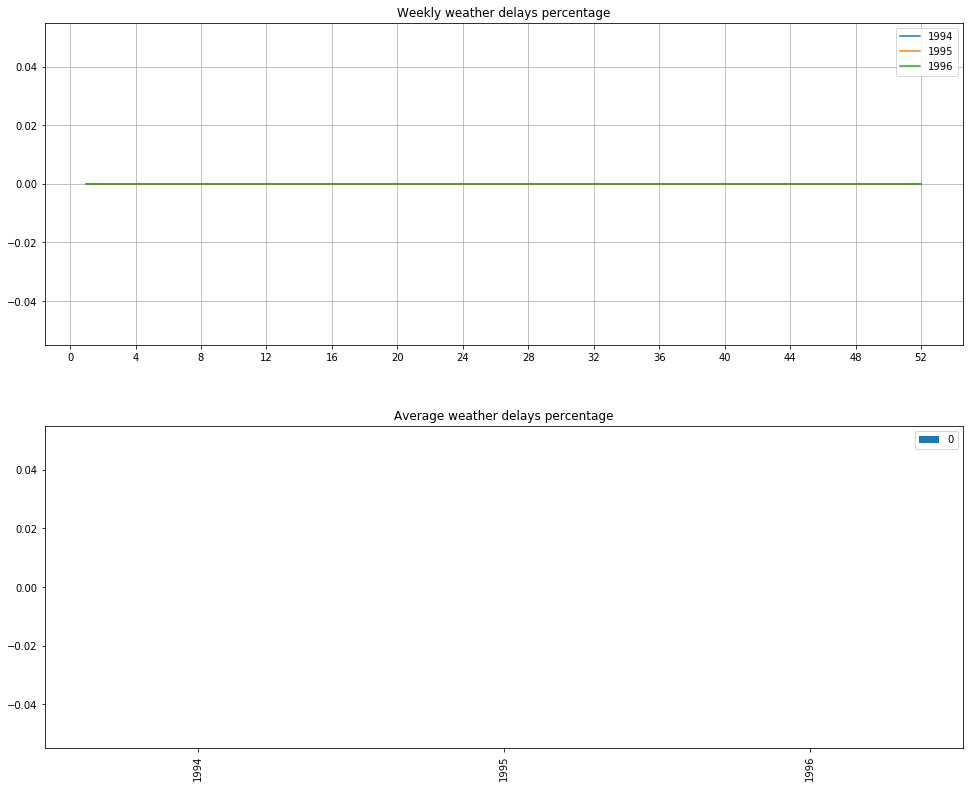

Output()

In [34]:
out = widgets.interactive_output(ui_callback, {'years': years_w, 'df': widgets.fixed(percentage_weather_delays)})
display(ui, out)